<a href="https://colab.research.google.com/github/nkthiebaut/guanaco/blob/main/notebooks/RoPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rotary Positional Embeddings: RoPE

Resources:
- Paper: https://arxiv.org/pdf/2104.09864
- Llama3 implementation: https://github.com/meta-llama/llama3/blob/main/llama/model.py
- Tutorial: https://github.com/naklecha/llama3-from-scratch

For a token in position $t$, RoPE rotates each dimension pair of the key and query vectors by

$$t \theta_i ,$$

 where $i\in [1, d/2]$ is the dimension pair index.

Common implementations use $\theta_{i}= 10000^{-\frac{i-1}{d/2}}$, i.e. the angular frequency $\theta_i$ is a geometric series of $i$.

In this notebook we'll implement RoPE in PyTorch.

In [ ]:
%pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 605.2 kB/s eta 0:00:00


## Compute the list of frequencies

We turn to the complex formulation fo those 2d rotations, e.g. for a query vector $q$:

$(q_1, q_2) ↦ qe^{it\theta_j}$ where $q=q_1+iq_2$.

In [ ]:
from einops import rearrange
import torch

T = 2
C = 2 # number of channels, i.e. hidden dimension

In [ ]:
c_values = torch.arange(1, C/2 + 1)
thetas = 10000 ** (2 * (c_values - 1) / C)  # Shape (C/2,)
timesteps = torch.arange(T)  # Shape (T,)

# Angular frequencies for each (t, c) pairs
omegas = torch.outer(timesteps, thetas)  # Shape (T, C/2)

# Turn those into complex numbers
z = torch.polar(torch.ones_like(omegas), omegas)

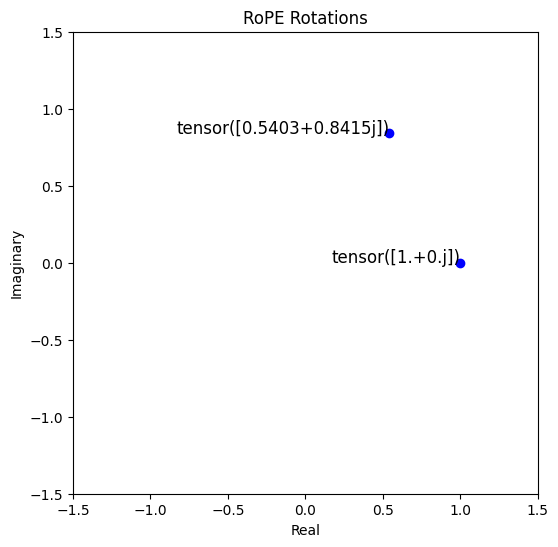

In [ ]:
import matplotlib.pyplot as plt


def plot_complex_numbers(z):
    plt.figure(figsize=(6, 6))
    plt.scatter(z.real, z.imag, color='blue')
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    for c in z:
        plt.text(c.real, c.imag, f'{c}', fontsize=12, ha='right')

    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.title('RoPE Rotations')


plot_complex_numbers(z)

## Exercise: use the complex numbers to rotate the query vector

Hint: use `torch.view_as_complex` and `torch.view_as_real` to switch representations.

In [ ]:
q = torch.randn(T, C)
print(q)
# q_rotated = ...

tensor([[ 0.1254, -0.8345],
        [ 0.6333,  0.7833]])


In [ ]:
q_pairs = rearrange(q, 'T (C p) -> T C p', p=2)  # Shape (T, C) -> (T, C/2, 2)

In [ ]:
q_complex = torch.view_as_complex(q_pairs)


tensor([[0.1254-0.8345j],
        [0.6333+0.7833j]])

In [ ]:
z

tensor([[1.0000+0.0000j],
        [0.5403+0.8415j]])

In [ ]:
q_rotated = q_complex * z

In [ ]:
torch.view_as_real(q_rotated)

tensor([[[ 0.1254, -0.8345]],

        [[-0.3170,  0.9561]]])

In [ ]:
# @title Solution
q_pairs = rearrange(q, 'T (C p) -> T C p', p=2)  # Shape (T, C) -> (T, C/2, 2)

q_complex = torch.view_as_complex(q_pairs)
q_rotated = q_complex * z
q_rotated = torch.view_as_real(q_rotated)  # Back to real numbers
q_rotated = rearrange(q_rotated, 'T C p -> T (C p)')  # Shape (T, C/2, 2) -> (T, C)
q_rotated

tensor([[ 0.6132,  1.6312],
        [-1.1338, -0.6542]])

## Exercise: implement RoPE for the general case (d>2)


In [ ]:
T = 2
C = 4
q = torch.randn(T, C) # Shape (T, C)

z = ...
q_rotated = ...

## Bonus: Llama3 implementation

In [ ]:
# from https://github.com/meta-llama/llama3/blob/14aab0428d3ec3a9596f1dea06d9c564f9c0e35f/llama/model.py#L49C1-L75C50

 def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)